[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zhimingkuang/Harvard-AM-115/blob/main/10_markov_chain/surfer_pagerank_demo.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, linalg, identity
import urllib
import re

In [2]:
def surfer(root,n):
    """Create the adjacency graph of a portion of the Web
    [U,G] = surfer(root,n) starts at the URL root and follows web links 
    until it forms an adjacency graph with n nodes
    U = a cell array of n strings, the URLs of the nodes
    G = an n-by-n sparse matrix with G(i,j)=1 if node j is linked to node i
    
    Example:  [U,G] = surfer('http://www.harvard.edu',500)

    This function currently has two defects:
    (1) Algorithm for finding links is naive, only look for the string 'http:'.
    (2) An attempt to read from a URL that is accessible, but very slow, might 
    take an unacceptably long time to complete.  In some cases, it may be necessary 
    to have the operating system terminate Python. Key words from such URLs can 
    be added to the skip list in surfer() function.
    
    Args:
        root (string): root URL
        n (int): number of nodes

    Returns:
        U (numpy.ndarray): the URLs of the nodes
        G (numpy.ndarray): an n-by-n sparse connectivity matrix
        
    """
    
    # Initialize
    U = np.empty(n, dtype=object)
    hashing = np.zeros(n)
    G = lil_matrix((n,n), dtype=bool) # note: use csr_matrix is also fine, but will
                                      # cause SparseEfficiencyWarning: Changing the 
                                      # sparsity structure of a csr_matrix is more
                                      # expensive. lil_matrix is more efficient.
    m = 0
    U[m] = root
    hashing[m] = hashfun(root)
    
    for j in range(n):
        # Try to open a page
        try:
            with urllib.request.urlopen(U[j]) as response:
                page = response.read().decode('utf-8')
            print('open ' + str(j) + ' ' + U[j])
        except:
            print('fail ' + str(j) + ' ' + U[j])
            continue
        
        # Follow the links from the open page
        urls = re.findall(r'http:\S+\w',page)
        for url in urls:
            # Look for links that should be skipped
            skips = ['.gif', '.ico', '.png', '.css', '.jpg', '.pdf', '.svg',\
                     'css', 'lmscadsi', 'cybernet', 'search.cgi', '.ram',\
                     '.php', '.me', 'www.w3.org', 'scripts', 'netscape', 'shockwave',\
                     'schema', 'foaf', 'purl', 'rdfs', 'webex', 'fansonly', '!', '?', ';', '}']
            # A link starts with 'http:' and ends with the next double quote
            isquote = url.find('\"')
            if isquote != -1:
                url = url[:isquote]
            for skip in skips:
                if url.find(skip) != -1:
                    avoid = True
                    if not (skip == '.gif' or 'css' or '.jpg'):
                        print('     skip ' + url)
                    break
                if url == 'http://':
                    avoid = True
                    break
                if url == 'http://www':
                    avoid = True
                    break
                avoid = False
            
            # Check if page is already in URL list
            found = 0
            if avoid:
                continue
            for k in np.argwhere(hashing == hashfun(url)):
                if U[k].all() == url:
                    found = int(k)
                    break
            
            # Add a new URL to the graph if are fewer than n
            if found == 0 and m < n-1:
                m += 1
                U[m] = url
                hashing[m] = hashfun(url)
                found = m      
                
            # Add a new URL
            if found > 0:
                G[found, j] = 1
                print('     link ' + str(found) + ' ' + url)
                
    return [U, G]

In [3]:
def hashfun(url):
    """Compute almost unique numeric hash code for pages already visited
    
    Args:
        url (string): page URL

    Returns:
        int: hash code
        
    """
    
    nums = [ord(c) for c in url]
    h = len(url) + 1024*sum(nums)
    
    return h

In [4]:
def pagerank(U, G, p=0.85):
    """Using the URLs and connectivity matrix produced by surfer(), together 
    with a damping factor p (default is .85) to compute and plot a bar graph
    of page rank, and print the dominant URLs in page rank order.
    
    Args:
        U (numpy.ndarray): the URLs of the nodes
        G (numpy.ndarray): an n-by-n sparse connectivity matrix
        p (float): damping factor

    Returns:
        x (numpy.ndarray): the page ranks
        
    """
    
    # Stochasticity adjustment
    n = np.size(G,1)
    np.where(np.sum(G,0) == 0, G, 1)
    
    # Eliminate any self-referential links
    csr_matrix.setdiag(G, np.zeros(n))
    
    # c = out-degree, r = in-degree
    c = np.zeros(n)
    r = np.zeros(n)
    c_2d = np.sum(G,0)
    r_2d = np.sum(G,1)
    for i in range(n):
        c[i] = c_2d[0,i]
        r[i] = r_2d[i,0]
        
    # Scale column sums to be 1
    k = np.squeeze( np.transpose( np.argwhere(c != 0) ) )
    D = csr_matrix( (1/np.squeeze(c[k]), (k,k)), shape=(n,n) )
    
    # Solve (I - p*G*D)*x = e
    e = np.ones(n)
    I = identity(n)
    x = linalg.lsqr(I - p*G*D, ((1-p)/n)*e)[0]
    
    # Normalize so that sum(x) == 1
    x = x / sum(x)
    
    # Plot bar graph of page rank
    fig, ax = plt.subplots(1,1,figsize=(9,7))
    ax.barh(U, x)
    ax.set_title('page rank')
    plt.show()
    
    # Print URL in page rank order
    indx = x.argsort(axis=0)[::-1] # change to descending order
    print("     page-rank  in  out  url")
    k = 0
    while k < n and (x[indx[k]] >= 0.005):
        j = indx[k]
        print(' %3.0f %8.4f %4.0f %4.0f  %s' % (j, x[j] ,r[j], c[j], U[j]))
        k += 1
    
    return x

In [5]:
# Customize for matplotlib
# If interested in the matplotlib object hierarchy, check: https://realpython.com/python-matplotlib-guide/
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['mathtext.default'] = 'regular'
# Change font size: http://www.futurile.net/2016/02/27/matplotlib-beautiful-plots-with-style/
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20

>Note: Results are slightly different from MATLAB!

In [6]:
[U,G] = surfer("https://www.fas.harvard.edu",20)

open 0 https://www.fas.harvard.edu
     link 1 http://theopenscholar.org
     link 2 http://www.harvard.edu
     link 2 http://www.harvard.edu
     link 3 http://www.fas.harvard.edu
     link 4 http://hr.harvard.edu
     link 5 http://www.directory.harvard.edu
open 1 http://theopenscholar.org
     link 1 http://theopenscholar.org
     link 1 http://theopenscholar.org
open 2 http://www.harvard.edu
     link 6 http://www.hbs.edu
     link 7 http://itatti.harvard.edu/berenson-library
     link 8 http://www.arboretum.harvard.edu
     link 9 http://ccva.fas.harvard.edu
     link 10 http://chsi.harvard.edu
     link 11 http://www.gsd.harvard.edu/exhibitions
     link 12 http://www.harvardartmuseums.org
     link 13 http://www.hmnh.harvard.edu
     link 14 http://hmsc.harvard.edu
     link 15 http://www.huh.harvard.edu
     link 16 http://mgmh.fas.harvard.edu
     link 17 http://www.mcz.harvard.edu
     link 18 http://www.peabody.harvard.edu
     link 19 http://commencement.harvard.edu
open 3

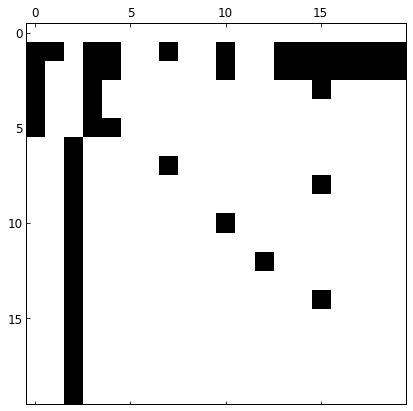

In [7]:
# Visualize the connectivity matrix
fig, ax = plt.subplots(1,1,figsize=(9,7))
ax.spy(G.todense())
ax.set_aspect('equal')
plt.show()

In [8]:
for idx,url in enumerate(U):
    print(idx, url)

0 https://www.fas.harvard.edu
1 http://theopenscholar.org
2 http://www.harvard.edu
3 http://www.fas.harvard.edu
4 http://hr.harvard.edu
5 http://www.directory.harvard.edu
6 http://www.hbs.edu
7 http://itatti.harvard.edu/berenson-library
8 http://www.arboretum.harvard.edu
9 http://ccva.fas.harvard.edu
10 http://chsi.harvard.edu
11 http://www.gsd.harvard.edu/exhibitions
12 http://www.harvardartmuseums.org
13 http://www.hmnh.harvard.edu
14 http://hmsc.harvard.edu
15 http://www.huh.harvard.edu
16 http://mgmh.fas.harvard.edu
17 http://www.mcz.harvard.edu
18 http://www.peabody.harvard.edu
19 http://commencement.harvard.edu


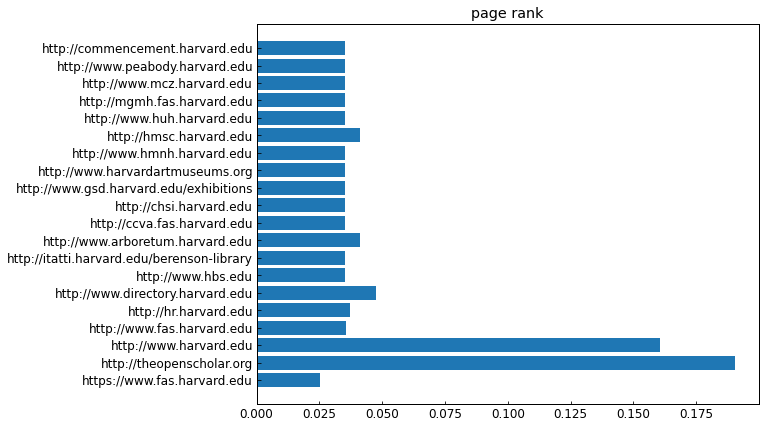

     page-rank  in  out  url
   1   0.1904   12    0  http://theopenscholar.org
   2   0.1606   11   14  http://www.harvard.edu
   5   0.0477    3    0  http://www.directory.harvard.edu
  14   0.0410    2    2  http://hmsc.harvard.edu
   8   0.0410    2    0  http://www.arboretum.harvard.edu
   4   0.0372    2    3  http://hr.harvard.edu
   3   0.0356    2    4  http://www.fas.harvard.edu
   7   0.0351    1    1  http://itatti.harvard.edu/berenson-library
  19   0.0351    1    2  http://commencement.harvard.edu
  17   0.0351    1    2  http://www.mcz.harvard.edu
  16   0.0351    1    2  http://mgmh.fas.harvard.edu
  13   0.0351    1    2  http://www.hmnh.harvard.edu
  10   0.0351    1    2  http://chsi.harvard.edu
  18   0.0351    1    2  http://www.peabody.harvard.edu
  15   0.0351    1    5  http://www.huh.harvard.edu
   9   0.0351    1    0  http://ccva.fas.harvard.edu
   6   0.0351    1    0  http://www.hbs.edu
  11   0.0351    1    0  http://www.gsd.harvard.edu/exhibitions
  12   

In [9]:
x = pagerank(U,G)